In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np

In [30]:
from collections import Counter
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [3]:
df = pickle.load(open('dataframe.pickle', 'rb'))
print(df.dtypes)
df.head()

issuercountrycode                        int64
txvariantcode                           object
bin                                    float64
amount                                 float64
currencycode                            object
shoppercountrycode                      object
shopperinteraction                      object
cardverificationcodesupplied            object
cvcresponsecode                          int64
creationdate                    datetime64[ns]
accountcode                             object
mail_id                                  int64
ip_id                                    int64
card_id                                  int64
label                                    int64
creationdate_timestamp                 float64
amount_distance                        float64
total_cards_used                         int64
dtype: object


,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,label,creationdate_timestamp,amount_distance,total_cards_used
0,76,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,True,0,2015-07-01,MexicoAccount,68370,111778,184798,1,1.435785e+09,0.0,1
1,76,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,True,0,2015-07-02,MexicoAccount,101299,78749,151595,1,1.435805e+09,0.0,1
2,76,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,True,0,2015-07-02,MexicoAccount,278604,70594,242142,1,1.435840e+09,0.0,1
3,76,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,True,0,2015-07-03,MexicoAccount,47409,113648,181744,1,1.435903e+09,0.0,1
4,76,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,True,0,2015-07-08,MexicoAccount,205501,83553,97271,1,1.436373e+09,0.0,1


In [4]:
# TODO: to verify, does this dataframe takes into account Refused transactions?
# How many entries in total ?
df.shape[0]

236698

In [5]:
# How many of those are fraudolent and how many are safe ?
s = df.label.value_counts()
print s
print s[1]/float(s[0])

0    236353
1       345
Name: label, dtype: int64
0.0014596810702635465


In [6]:
# TODO clean and filter only the interesting features, this is just an example:
df_interesting = df[['label','ip_id','issuercountrycode','amount_distance','total_cards_used']]
df_interesting.loc[:,('issuercountrycode')] = df_interesting['issuercountrycode'].fillna('??') # We add a custom value for unknown codes

/home/luigi/Desktop/my_lab/UNI/SaP_Master/UT/Q4/CDA/penv/local/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
# Creating training and test sets
training_features, test_features, \
training_target, test_target, = train_test_split(df_interesting.drop(['label'], axis=1),
                                               df_interesting['label'],
                                               test_size = .1,
                                               random_state=12)


In [22]:
# SMOTE analysis (note, this is done after sampling)
sm = SMOTE(random_state=12)
x_res, y_res = sm.fit_sample(training_features, training_target)
print training_target.value_counts()
print np.bincount(y_res)


0    212717
1       311
Name: label, dtype: int64
[212717 212717]


In [23]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(x_res, y_res)
print dt.score(test_features,test_target)
y_predict = dt.predict(test_features)
tn, fp, fn, tp = confusion_matrix(test_target,y_predict).ravel()
print tn, fp, fn, tp

0.9217997465145754
21802 1834 17 17


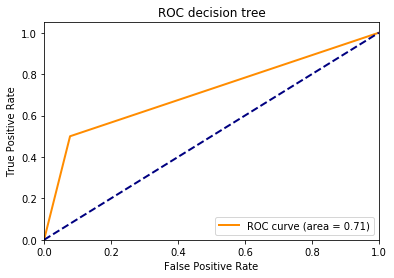

In [32]:
fpr, tpr, thresholds = roc_curve(test_target, y_predict)
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC decision tree')
plt.legend(loc="lower right")
plt.show()

In [16]:
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None,
                               feature_names=list(df_interesting.columns.values[1:]),
                               class_names=['ok','fraud'],filled=True, rounded=True,  
                               special_characters=True
                              ) 
graph = graphviz.Source(dot_data) 
graph

KeyboardInterrupt: 